In [ ]:
!pip3 install "gymnasium[atari, accept-rom-license]" opencv-python "stable-baselines3[extra]" pygame matplotlib

In [1]:
import gymnasium as gym
from gymnasium import spaces

import pygame

import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.autograd import Variable
from torchvision.transforms import v2

from stable_baselines3 import PPO

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
objc[92137]: Class SDLApplication is implemented in both /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pygame/.dylibs/libSDL2-2.0.0.dylib (0x12b0ea5e8) and /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ale_py/libSDL2-2.0.dylib (0x1364d1088). One of the two will be used. Which one is undefined.
objc[92137]: Class SDLAppDelegate is implemented in both /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pygame/.dylibs/libSDL2-2.0.0.dylib (0x12b0ea638) and /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ale_py/libSDL2-2.0.dylib (0x1364d10d8). One of the two will be used. Which one is undefined.
objc[92137]: Class SDLTranslatorResponder is implemented in both /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pygame/.dylibs/libSDL2-2.0.0.dylib (0x12b0ea6b0) and /Librar

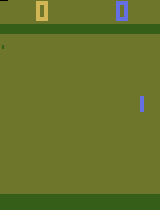

In [2]:
env = gym.make("ALE/Pong-v5", render_mode="human")
env.obs_type = "grayscale"
observation, info = env.reset()
Image.fromarray(observation)

In [3]:
device = torch.device("cuda")

In [4]:
height = observation.shape[0]
width = observation.shape[1]
channels = observation.shape[2]

In [5]:
process = transforms.Compose([
    transforms.ToTensor()
])

In [6]:
observation = process(observation)
observation = observation.unsqueeze(0).to(device)

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        input = input.view(input.size(0), -1)
        return input

class UnFlatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 256, 11, 8)

class VAE(nn.Module):
    def __init__(self, image_channels=3, height=height, width=width):
        super(VAE, self).__init__()

        self.height = height
        self.width = width
        
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=4, stride=2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        latent = self.encoder(x)
        return self.decoder(latent), latent.to("cpu").detach().numpy()

# Model Initialization
VAE_model = VAE().to(device)
 
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
 
# Using an Adam Optimizer
optimizer = torch.optim.Adam(VAE_model.parameters())

In [7]:
print(observation.shape)
x_hat, latent = VAE_model(observation)
print(x_hat.shape)
print(latent.shape)

torch.Size([3, 210, 160])


NameError: name 'VAE_model' is not defined

In [ ]:
losses = []
for _ in range(10000):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)

    observation = process(observation).unsqueeze(0).to(device)
    reconstruction, latent = VAE_model(observation)
    loss = loss_function(reconstruction, observation[:, :, :206, :158])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss)

    if terminated or truncated:
        observation, info = env.reset()
env.close()

In [ ]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

num_losses = []

for x in losses:
    num_losses.append(x.item())

plt.plot(num_losses)

In [ ]:
transforms.functional.to_pil_image(observation.view(3, height, width))

In [ ]:
decoded_image = transforms.functional.to_pil_image(reconstruction.view(3, 206, 158))
decoded_image

In [ ]:
torch.save(VAE_model.state_dict(), "vae_model.pth")

In [ ]:
VAE_model = VAE().to(device)
VAE_model.load_state_dict(torch.load("vae_model.pth"))
VAE_model.eval()

In [ ]:
class LatentWrapper(gym.Env):
    def __init__(self, other_env, size):
        self.other_env = other_env
        
        self.observation_space = spaces.Box(low=0, high=255, shape=(1, size), dtype=np.float32)
        self.action_space = self.other_env.action_space
        
    def reset(self, seed=None, options=None):
        observation, info = self.other_env.reset(seed=seed, options=options)
        
        observation = process(observation).unsqueeze(0).to(device)
        reconstruction, latent = VAE_model(observation)
        
        loss = loss_function(reconstruction, observation[:, :, :206, :158])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        before = transforms.functional.to_pil_image(observation.view(3, height, width))
        after = transforms.functional.to_pil_image(reconstruction.view(3, 206, 158))

        return latent, info

    def step(self, action):
        observation, reward, terminated, truncated, info = self.other_env.step(action)
        
        observation = process(observation).unsqueeze(0).to(device)
        reconstruction, latent = VAE_model(observation)
        
        loss = loss_function(reconstruction, observation[:, :, :206, :158])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return latent, reward, terminated, truncated, info
        
    def close(self):
        self.other_env.close()

In [ ]:
wrapper_env = LatentWrapper(env, 22528)

In [ ]:
model = PPO("MlpPolicy", wrapper_env, verbose=0)

In [ ]:
model = PPO.load("Pong", env=wrapper_env)
obs = wrapper_env.reset()

In [ ]:
model.learn(total_timesteps=40000, progress_bar=False)

In [ ]:
wins = []
win_count = 0

obs, info = wrapper_env.reset()

for _ in range(1000):
    action, _states = model.predict(obs)
    obs, reward, terminated, truncated, info = wrapper_env.step(action)
    if reward == 1:
        win_count += 1
    wins.append(win_count)
    if terminated or truncated:
        obs, info = wrapper_env.reset()

In [ ]:
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Wins')

plt.plot(wins)

In [ ]:
model.save("Pong")

In [ ]:
torch.save(VAE_model.state_dict(), "vae_model.pth")